# Setup

Importing libraries

In [1]:
import numpy as np
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
from librosa.feature import mfcc, delta
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from hmmlearn import hmm
import warnings
warnings.filterwarnings('ignore')

Constants

In [2]:
# spoken commands
utterances = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes"]
# sampling rate
fs = 16000

Utility functions

In [3]:
# function to read audio file
def read_file(path):
    return wavfile.read(path)[1]

# function to perform speech endpointing
def speech_endpointing(
        audio,
        frame_length=int(fs*20e-3), # 20ms
        hop_length=int(fs*10e-3) # 10ms
        ):
    
    total_energy = np.sum(audio**2)
    threshold = 0.05 * total_energy # upper bound/threshold for silence

    window = np.hamming(frame_length)
    audio_size = audio.size
    num_frames = audio_size//hop_length - 1
    
    endpoint = []
    # starting index of speech
    for frame in range(num_frames):
        st = frame*hop_length
        data = window*audio[st:st+frame_length]
        frame_energy = np.sum(data**2)
        if frame_energy > threshold:
            # take 100ms before the detected start point so we don't miss fricatives/plosives
            endpoint.append(max(0, st-1600))
            break
    # terminating index of speech
    for frame in range(num_frames):
        ed = (num_frames-frame)*hop_length
        data = window*audio[st:st+frame_length]
        frame_energy = np.sum(data**2)
        if frame_energy > threshold:
            endpoint.append(ed)
            break
    
    if len(endpoint) == 2:
        return endpoint
    else: # if the thresholding fails, then take the entire speech signal
        return [0, num_frames*hop_length]

# pre-emphasis function from previous assignment
def preemphasis(x, coef=0.95):
    y = np.zeros_like(x)
    y[0] = x[0]
    y[1:] = x[1:] - coef * x[:-1]
    return y

# function to compute the mfcc coefficients and return the total 39 features of a speech signal
def mfcc_coeffs(audio):
    mfccs = mfcc(
        y=audio, sr=fs, n_mfcc=13,
        win_length=int(fs*20e-3), # 20ms
        hop_length=int(fs*10e-3), # 10ms
        window=np.hamming(int(fs*20e-3)) # 20ms, window size = frame size
        )
    return np.concatenate((
        mfccs, # 13 mfcc coeffs
        delta(mfccs, order=1), # 13 first oreder differences
        delta(mfccs, order=2) # 13 second oreder differences
    )) # total 39 features

# function to return the features of an audio file after performing endpointing and pre-emphasis
def feature_extraction(path):
    audio = read_file(path) # read
    norm_audio = audio / np.abs(audio).max() # normalize
    endpoints = speech_endpointing(norm_audio) # endpoints
    return mfcc_coeffs( # get the features after
        preemphasis( # applying pre-emphasis to the
            norm_audio[endpoints[0]:endpoints[1]] # end-pointed speech signal
            )
    )

Functions for training, and generating predictions of the VQ codebook matching technique

In [ ]:
def train_codebook(L, train_type, utterances=utterances):
    # dictionary to store the prototypical vectors for each utterance
    centroids = {}
    # loop over each word/utterance in the dataset
    for utt in utterances:
        # loop over all the audio files
        for i, file_name in enumerate(os.listdir(f"../Commands Dataset/{train_type}/{utt}")):
            path = os.path.join(os.pardir, f"Commands Dataset\\{train_type}\\{utt}", file_name)
            # get the features
            f = feature_extraction(path)
            if i == 0:
                features = f
            else:
                features = np.concatenate((features, f), axis=1)
        # instantiate the K-means clustering model from the scikit-learn library
        model = KMeans(n_clusters=L, init='random', n_init='auto')
        # train it on the features of a single utterance
        model.fit(features.T)
        # store the prototypical vectors
        centroids[utt] = model.cluster_centers_
    return centroids

def test_codebook(centroids_dict, test_type, utterances=utterances):
    # maintain lists for real and predicted labels
    actual, predicted = [], []
    # loop over each word/utterance in the dataset
    for i, utt in enumerate(utterances):
        # loop over all the audio files
        for file_name in os.listdir(f"../Commands Dataset/test_{test_type}/{utt}"):
            # its real/actual label
            actual.append(i)
            path = os.path.join(os.pardir, f"Commands Dataset\\test_{test_type}\\{utt}", file_name)
            # get the features
            f = feature_extraction(path)
            # maintain a list to store the min distortions of the test utterance from each of the refernce utterancse
            min_distortion_utt = []
            for ut in utterances:
                # maintain a variable for the summation of the min distortions of eaech frame
                min_distortion_frames = 0
                # loop over all frames of the test utterance
                for frame in range(f.shape[1]):
                    # add the min distortion to the variable
                    min_distortion_frames += np.min(np.sqrt(np.sum((centroids_dict[ut] - f[:, frame])**2, axis=1)))
                # store the min distortion from each reference utterance
                min_distortion_utt.append(min_distortion_frames)    
            # prediction is the one which has the lowest distortion
            predicted.append(np.argmin(min_distortion_utt))
    return actual, predicted

Functions for training, and generating predictions of the GMM-HMM models

In [ ]:
def train_gmmhmm(hmm_states, train_type, covariance_type='diag', n_mix=10, n_iter=10, utterances=utterances):
    # dictionary to store the trained models
    models = {}
    # loop over all utterances in the dataset
    for utt in utterances:
        # initialize array/list to store the length (no. of frames) and features of each audio file
        size = np.zeros(len(os.listdir(f"../Commands Dataset/{train_type}/{utt}")), dtype=int)
        features = []
        # loop over all the audio files
        for i, file_name in enumerate(os.listdir(f"../Commands Dataset/{train_type}/{utt}")):
            path = os.path.join(os.pardir, f"Commands Dataset\\{train_type}\\{utt}", file_name)
            # get the features
            f = feature_extraction(path)
            # store the length and the actual features
            size[i] = f.shape[1]
            features.append(f.T)
        # instantiate the GMM-HMM model from the hmmlearn python library
        model = hmm.GMMHMM(n_components=hmm_states, covariance_type=covariance_type, n_mix=n_mix, n_iter=n_iter, verbose=False)
        # train it on the features of a single utterance
        model.fit(np.vstack(features), lengths=size)
        # store the complete model
        models[utt] = model
    return models

def test_gmmhmm(models_dict, test_type, utterances=utterances):
    # maintain lists for storing the real and predicted labels
    actual, predicted = [], []
    # loop over all utterances
    for i, utt in enumerate(utterances):
        # loop over all audio files
        for file_name in os.listdir(f"../Commands Dataset/test_{test_type}/{utt}"):
            # store the real/actual label
            actual.append(i)
            path = os.path.join(os.pardir, f"Commands Dataset\\test_{test_type}\\{utt}", file_name)
            # get the features
            f = feature_extraction(path) 
            # the prediction is the one for which the "score" given by the GMM-HMM model is the highest
            predicted.append(np.argmax([models_dict[ut].score(f.T) for ut in utterances]))
    return actual, predicted

Funtion to evaluate: compute accuracy and generate the confusoin matrix for the model predictions

In [ ]:
def evaluate(actual, predicted, utterances=utterances):
    # compute and print the accuracy upto 3 decimal places
    print(f"Accuracy: {accuracy_score(actual, predicted)*100:0.3f} %")
    # generate the confusion matrix
    cm = confusion_matrix(actual, predicted)
    # plot it
    plt.figure(figsize=(8, 8))
    # add labels for each word in the plot instead of using indices
    tick_marks = np.arange(len(utterances))
    plt.xticks(tick_marks, utterances)
    plt.yticks(tick_marks, utterances)
    # plot using the seaborn library
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=utterances, yticklabels=utterances)
    # add title etc.
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    # display the confusion matrix
    plt.show()

Function to add 10 dB SNR noise given along with the dataset

In [ ]:
def add_noise(speechfile, noisefile, outputfile):
    
    #reading the .wav files
    sampFreq, noise = wavfile.read(noisefile)
    sampFreq, speech = wavfile.read(speechfile)
    numSamples = len(speech)

    #clipping a segment of noise from a random position, with segment length equal to the length of speech 
    i = np.random.choice(np.arange(len(noise) - numSamples))
    noise = noise[i:i+numSamples]

    #converting the PCM values to floats with range from -1.0 to 1.0
    speech = speech/32768
    noise = noise/32768

    #normalizing the noise and adding it to the speech
    rawEnergy = np.sum(speech**2)
    noise = noise*(np.sqrt(rawEnergy/(10*np.sum(noise**2))))
    speech = speech + noise

    #normalizing the noisy speech so that its energy equals the energy of raw speech
    speech = speech*(np.sqrt(rawEnergy/np.sum(speech**2)))

    #converting the floats back to PCM values
    speech = speech*32767
    speech = speech.astype(np.int16)

    #saving the noisy speech to the output file
    wavfile.write(outputfile, sampFreq, speech)
    
    return

Creating the noisy training dataset

In [ ]:
# list to store the paths to the noise files
noise_file_paths = [
    os.path.join(os.pardir, f"Commands Dataset\\_background_noise_", noise) for noise in os.listdir("../Commands Dataset/_background_noise_")
    ]

# loop over each utterance in the dataset
for utt in utterances:
    # loop over all the audio files
    for i, file_name in enumerate(os.listdir(f"../Commands Dataset/train/{utt}")):
        # path to the original audio file
        clean_path = os.path.join(os.pardir, f"Commands Dataset\\train\\{utt}", file_name)
        # path at which to store the new audio file
        noisy_path = os.path.join(os.pardir, f"Commands Dataset\\train_noisy\\{utt}", file_name)

        if np.random.rand() < 0.5: # with probability 0.5
            noise_file = np.random.choice(noise_file_paths) # select the noise file randomly
            add_noise(clean_path, noise_file, noisy_path) # add 10 dB SNR noise and save the audio file
        else:
            audio = read_file(clean_path) # just copy
            wavfile.write(noisy_path, fs, audio) # and paste the "clean" audio file

Verifying the speech end-pointing function

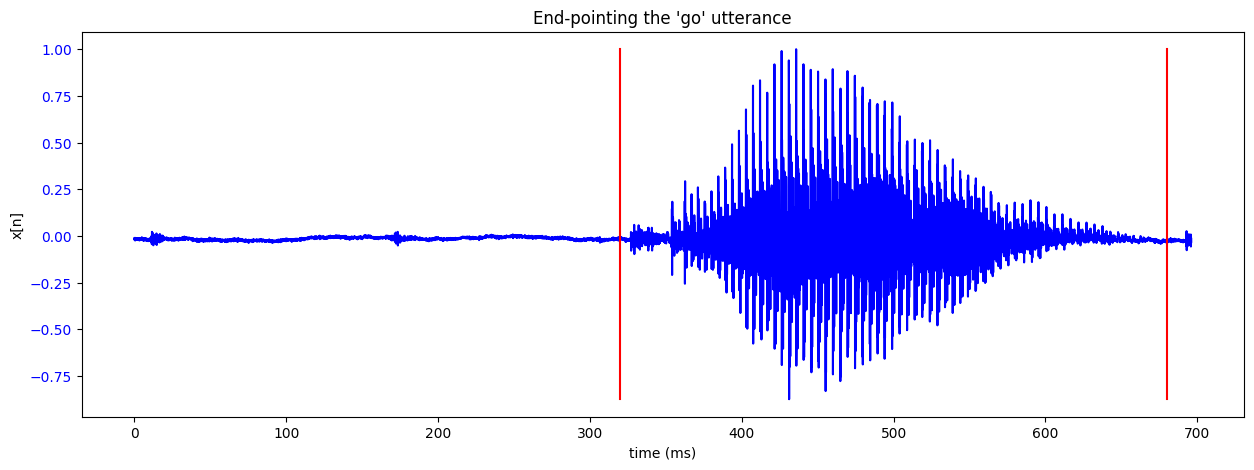

In [5]:
# choose an utterance
utt = "go"
# get the first audio file in the corresponding folder
path = os.path.join(os.pardir, f"Commands Dataset\\train\\{utt}", os.listdir(f"../Commands Dataset/train/{utt}")[0])
data_ = read_file(path)
data = data_ / np.abs(data_).max()
# perform speech endpointing and get the endpoints
endpoints = speech_endpointing(data)

# display the original audio file along with the locations of the endpoints
plt.figure(figsize=(15, 5))
time_axis = np.linspace(0, data.shape[0]*1000//fs, data.shape[0])
plt.plot(time_axis, data, c='b')
plt.tick_params(axis='y', labelcolor='b')
plt.ylabel("x[n]")
plt.xlabel("time (ms)")
plt.title(f"End-pointing the '{utt}' utterance")
plt.plot([endpoints[0]*1000//fs]*2, [data.max(), data.min()], c='r')
plt.plot([endpoints[1]*1000//fs]*2, [data.max(), data.min()], c='r')
plt.show()

We observe that the endpointing results are quite good.

# Task A: Recognition of clean speech utterances

We have already defined the training, testing and plotting functions above, so now we just need to call those functions.

## VQ codebook matching

In [ ]:
centroids = train_codebook(40, "train") # considering 40 prototypical vectors and training on the clean dataset

In [ ]:
actual, predicted = test_codebook(centroids, "clean") # predicting the utterances in the clean test audio files

Accuracy: 66.965 %


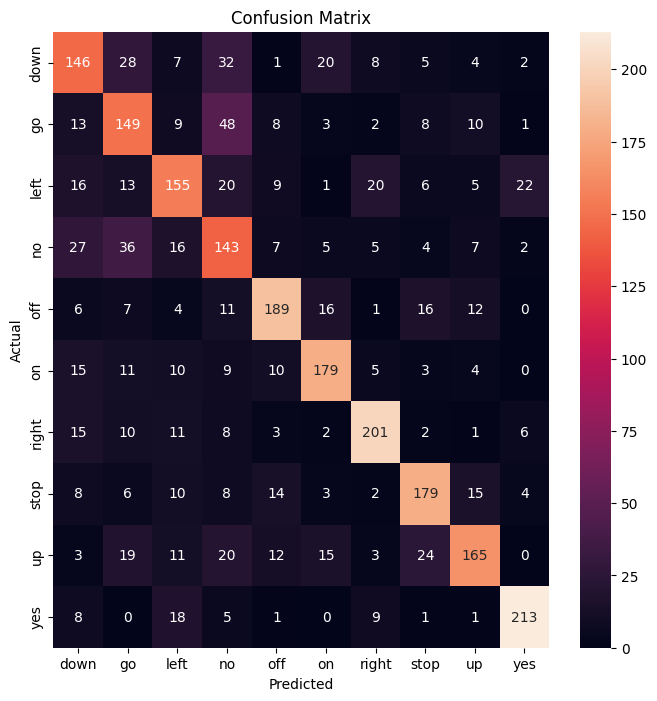

In [ ]:
evaluate(actual, predicted) # computing the accuracy, and displaying the confusion matrix

For the clean data, we achieve approx. 67% accuracy.
### Observations:
- The diagonal entries are the most populated which is a sign that the predictions are correct most of the time.
- We observe that the pair of utterances <i>/go/</i>, and <i>/no/</i> suffer from high confusion.
- Two more pairs: <i>/off/</i>, <i>/on/</i> and <i>/stop/</i>, <i>/up/</i> also suffer from some confusion, but its not very high.

The confusion is occurring between the words that have common phones. Hence, we can clearly see that the VQ codebook method gives low accuracy becuase it cannot utilize the temopral information present in the audio signal (and its features).
### Improvements:
- We can try to improve the accuracy by increasing the number of prottypical vectors used (the no. of clusters formed).
- Another approach might be to co-train the models, such that not only are the prototypical vectors close to the cluster centers, but they are also far away from the points of a different utterance in the feature space. This method would be helpful especially for the words that have common phones and cause confusion to the model.

## GMM-HMM

In [ ]:
models = train_gmmhmm(16, "train") # considering the HMM to have 16 states and training on the clean dataset

In [ ]:
actual, predicted = test_gmmhmm(models, "clean") # predicting the utterances in the clean test audio files

Accuracy: 93.533 %


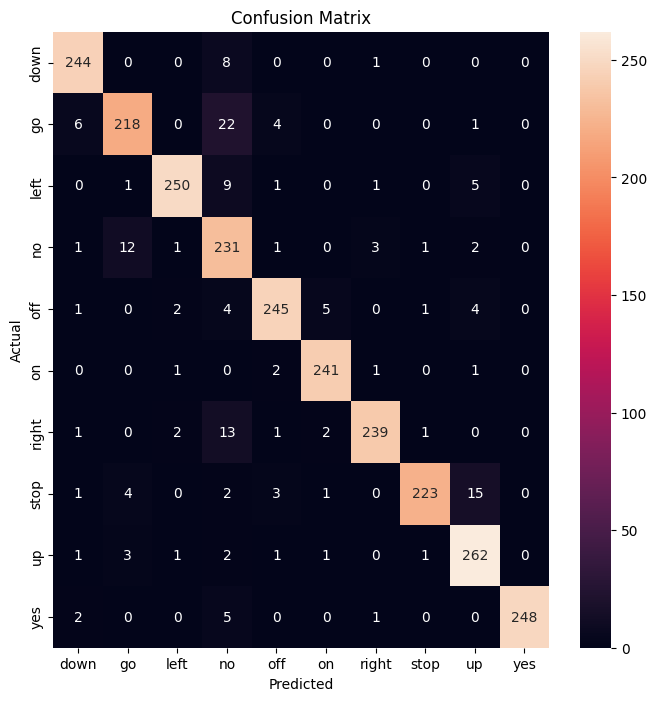

In [ ]:
evaluate(actual, predicted) # computing the accuracy, and displaying the confusion matrix

For the clean data, we achieve approx. <b>94</b>% accuracy.
### Observations:
- The diagonal entries are the most populated which is a sign that the predictions are correct most of the time.
- We observe that there are no word pairs that suffer from high confusion.
- It is good to note that all the samples predicted to be <i>/yes/</i> were indeed utterances of <i>/yes/</i> (it has a true positive rate of 1).
### Improvements:
GMM-HMM is a statistcal model, so the main ways to improve the accuracy would be:
- We can fine-tune the number of states in the HMM to different for each word, i.e. increase/decrease the number of states depending on the length of the word or the number of phones in it.
- Using phone-level HMMs instead of word-level HMMs may or may not improve accuracy.
- Increase the number of parameters used by the GMM, i.e. choose to obtain an arbitrary gaussian distribution instead of one with only the diagonal elements as non-zero.

# Task B: Recognition of noisy utterances

## VQ codebook matching

In [ ]:
centroids = train_codebook(40, "train_noisy") # considering 40 prototypical vectors and training on the noisy dataset

In [ ]:
actual, predicted = test_codebook(centroids, "noisy") # predicting the utterances in the noisy test audio files

Accuracy: 52.707 %


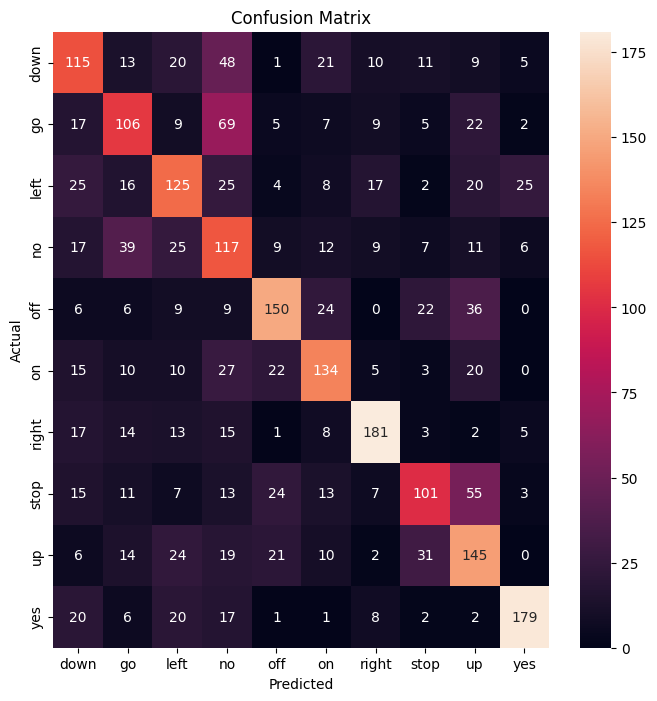

In [ ]:
evaluate(actual, predicted)  # computing the accuracy, and displaying the confusion matrix

For the noisy data, we achieve approx. 53% accuracy.
### Observations:
- Compared to the clean data, the accuracy has decreased a lot (by 14%!).
- We obsereve very high confusion for among the first four utterances: <i>/down/</i>, <i>/go/</i>, <i>/left/</i>, and <i>/no/</i>.
- The confusion among the pairs of utterances <i>/off/</i>, <i>/on/</i> and <i>/stop/</i>, <i>/up/</i> has increased than for the clean data.
- The words <i>/right/</i>, and <i>/yes/</i> seem to be the easiest to predict correctly, as they don't have confusion with other utterances.
### Improvements:
- We can try to improve the accuracy by increasing the number of prottypical vectors used (the no. of clusters formed).
- The main reason for the bad accuracy according to me is noise. So, we could use some noise-removal techniques before computing the mfcc and other features. These techniques might be deep learning based or more theoretical too.
- Another approach might be to pass the signal through various band-pass filters. Then, we could choose the frequency band that has the least amount of noise (or high SNR) for the further process of feature extraction. However, we would  need prototypical vectors for each frequency band and so the memory constraints of this method might be very high.

## GMM-HMM

In [ ]:
models = train_gmmhmm(16, "train_noisy") # considering the HMM to have 16 states and training on the noisy dataset

In [ ]:
actual, predicted = test_gmmhmm(models, "noisy") # predicting the utterances in the noisy test audio files

Accuracy: 88.508 %


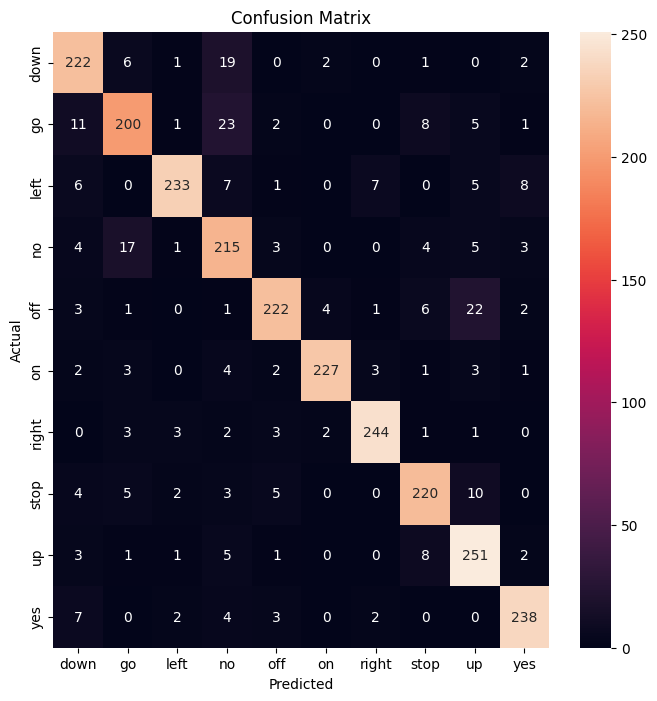

In [ ]:
evaluate(actual, predicted)  # computing the accuracy, and displaying the confusion matrix

For the noisy data, we achieve approx. <b>89</b>% accuracy.
### Observations:
- Compared to the clean data, the accuracy hasn't decreased as much (just by 5%) when compared to the VQ codebook method. So, we can say that the GMM-HMM method is more robust to noise.
- The diagonal entries are the most populated which is a sign that the predictions are correct most of the time.
- We observe that there are no word pairs that suffer from high confusion.
### Improvements:
GMM-HMM is a statistcal model, so the main ways to improve the accuracy would be:
- Agaain, doing some noise removal/suppressing steps might help improve the accuracy.
- We can fine-tune the number of states in the HMM to different for each word, i.e. increase/decrease the number of states depending on the length of the word or the number of phones in it.
- Using phone-level HMMs instead of word-level HMMs may or may not improve accuracy.
- Increase the number of parameters used by the GMM, i.e. choose to obtain an arbitrary gaussian distribution instead of one with only the diagonal elements as non-zero.